# K-Nearest Neighbors

## The Three Steps

## Finding the neighbors

## Selecting K

# Problem Statement

## Import Libraries

In [1]:
# Base Libraries
import pandas as pd
import numpy as np

# data
import yfinance as yf
from pathlib import Path

# Plotting
import matplotlib.pyplot as plt

# plt.rcParams['figure.figsize'] = (20,7)
# plt.style.use('fivethirtyeight')
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score

# Classifier
from sklearn.neighbors import KNeighborsClassifier

# metrics
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    auc,
)
from sklearn.metrics import classification_report, confusion_matrix

# Ignore warnings
import warnings

warnings.filterwarnings("ignore")

## Load Data

In [37]:
# Get yahoo tickers for indian stocks
df_path = Path(".data/spy.csv")

if df_path.exists():
    # Read from file
    df = pd.read_csv(df_path, index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index, utc=True)
else:
    df_path.parent.mkdir(parents=True, exist_ok=True)

    df = yf.download('SPY',
        start = "2000-01-01",
        end = "2020-02-01",
        # period='20y',
    )

    # write data to file for future use
    df.to_csv(df_path)

# Display dataframe
pd.concat([df.head(), df.tail()])

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03 05:00:00+00:00,148.250000,148.250000,143.875000,145.437500,94.262566,8164300
2000-01-04 05:00:00+00:00,143.531250,144.062500,139.640625,139.750000,90.576332,8089800
2000-01-05 05:00:00+00:00,139.937500,141.531250,137.250000,140.000000,90.738365,12177900
2000-01-06 05:00:00+00:00,139.625000,141.500000,137.750000,137.750000,89.280045,6227200
2000-01-07 05:00:00+00:00,140.312500,145.750000,140.062500,145.750000,94.465080,8066500
2020-01-27 05:00:00+00:00,323.029999,325.119995,322.660004,323.500000,305.003571,84062500
2020-01-28 05:00:00+00:00,325.059998,327.850006,323.600006,326.890015,308.199768,63834000
2020-01-29 05:00:00+00:00,328.380005,328.630005,326.399994,326.619995,307.945221,53888900
2020-01-30 05:00:00+00:00,324.359985,327.910004,323.540009,327.679993,308.944580,75491800


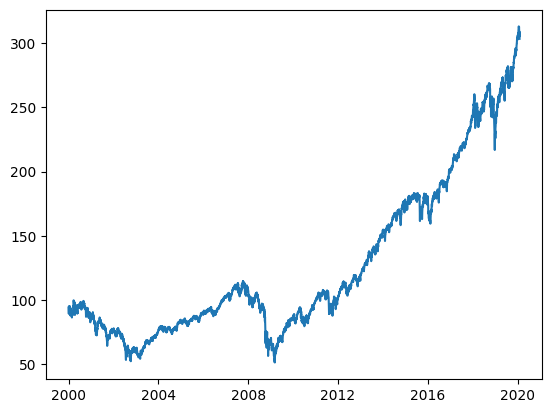

In [4]:
# Visualize data
plt.plot(df['Adj Close'])

## EDA of Original dataset

In [5]:
# Descriptive statistics
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5052.000000,5052.000000,5052.000000,5052.000000,5052.000000,5.052000e+03
mean,158.322465,159.216604,157.332570,158.322124,127.581357,1.120182e+08
std,59.291420,59.359388,59.193415,59.301188,62.775577,9.847915e+07
min,67.949997,70.000000,67.099998,68.110001,51.386772,1.436600e+06
25%,115.495001,116.407503,114.617502,115.650002,82.764700,4.779688e+07
50%,136.509995,137.281250,135.480003,136.489998,100.630241,8.276585e+07
75%,199.325005,200.387505,198.512501,199.462498,170.268684,1.506240e+08
max,332.440002,332.950012,331.170013,331.950012,312.970520,8.710263e+08


## Cleaning & Imputation

In [6]:
# Check for missing values
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Feature Specification

In [7]:
# Predictors
df['O-C'] = df.Open - df.Close
df['H-L'] = df.High - df.Low
X = df[['O-C', 'H-L']].values
X

array([[ 2.8125    ,  4.375     ],
       [ 3.78125   ,  4.421875  ],
       [-0.0625    ,  4.28125   ],
       ...,
       [ 1.76000977,  2.23001099],
       [-3.32000732,  4.36999512],
       [ 5.26998901,  6.44000244]])

## Target or Label Definition

In [8]:
# Target- Avoid using [-1, 1], always prefer [0, 1] as class labels
y = np.where(df['Adj Close'].shift(-1)>0.995*df['Adj Close'],1,-1)
y

array([-1,  1, -1, ...,  1, -1, -1])

In [9]:
# Value counts for class 1 and -1
pd.Series(y).value_counts()

 1    3847
-1    1205
dtype: int64

In [10]:
# Splitting the datasets into training and testing data.
# Always keep shuffle = False for financial time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)

In [11]:
# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 4041, 1011


# Base Model

## Fit Model

In [12]:
# Scale and fit the model
model = Pipeline([("scaler", MinMaxScaler()), ("classifier", KNeighborsClassifier())])
model.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier', KNeighborsClassifier())])

## Predict Model

In [13]:
# Predicting the test dataset
y_pred = model.predict(X_test)

# Predict Probabilities
y_proba = model.predict_proba(X_test)

In [14]:
# verify the class labels
model.classes_

array([-1,  1])

In [15]:
# predict probability
y_proba[-20:]

array([[0.6, 0.4],
       [0. , 1. ],
       [0. , 1. ],
       [0.4, 0.6],
       [0.2, 0.8],
       [0.6, 0.4],
       [0.6, 0.4],
       [0.2, 0.8],
       [0.4, 0.6],
       [0.4, 0.6],
       [0.2, 0.8],
       [0.2, 0.8],
       [0. , 1. ],
       [0.2, 0.8],
       [0.4, 0.6],
       [0.6, 0.4],
       [0.4, 0.6],
       [0. , 1. ],
       [0.4, 0.6],
       [0.2, 0.8]])

In [16]:
# predict class labels
y_pred[-20:]

array([-1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1])

In [17]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
print(f"Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4}")

Train Accuracy: 0.7785, Test Accuracy: 0.7517


## Prediction Quality

### Confusion Matrix

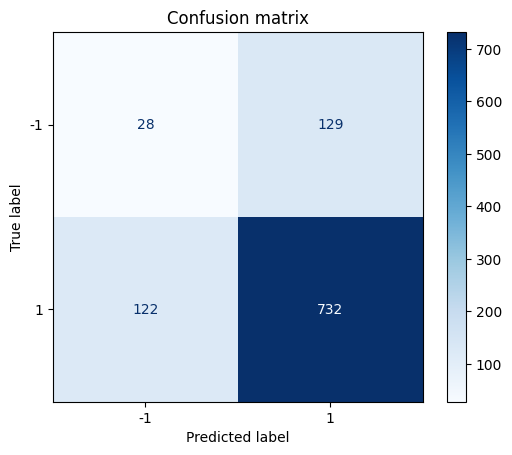

In [18]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    # display_labels=model.classes_,
    cmap=plt.cm.Blues,
)
plt.title("Confusion matrix")
plt.show()

### Classification Report

In [19]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.19      0.18      0.18       157
           1       0.85      0.86      0.85       854

    accuracy                           0.75      1011
   macro avg       0.52      0.52      0.52      1011
weighted avg       0.75      0.75      0.75      1011



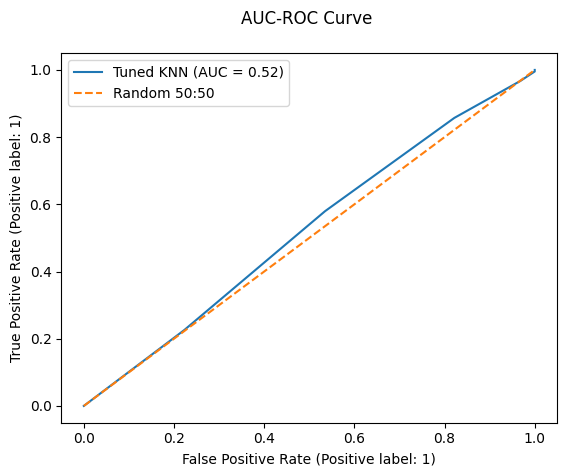

In [20]:
# Display ROCCurve
disp = RocCurveDisplay.from_estimator(model, X_test, y_test, name="Tuned KNN")
plt.title("AUC-ROC Curve \n")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random 50:50")
plt.legend()
plt.show()

# Hyper-parameter Tuning

## Cross-validation of Time Series

In [57]:
# Example: First 2 split
tscv = TimeSeriesSplit(n_splits=4, gap=1)
for train, test in tscv.split(X):
    print(train, test)

[   0    1    2 ... 1008 1009 1010] [1012 1013 1014 ... 2019 2020 2021]
[   0    1    2 ... 2018 2019 2020] [2022 2023 2024 ... 3029 3030 3031]
[   0    1    2 ... 3028 3029 3030] [3032 3033 3034 ... 4039 4040 4041]
[   0    1    2 ... 4038 4039 4040] [4042 4043 4044 ... 5049 5050 5051]


In [58]:
# Cross-validation
tscv = TimeSeriesSplit(n_splits=8, gap=1)

## GridSearch

In [59]:
# Get parameters list
model.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()), ('classifier', KNeighborsClassifier())],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'classifier': KNeighborsClassifier(),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'classifier__algorithm': 'auto',
 'classifier__leaf_size': 30,
 'classifier__metric': 'minkowski',
 'classifier__metric_params': None,
 'classifier__n_jobs': None,
 'classifier__n_neighbors': 5,
 'classifier__p': 2,
 'classifier__weights': 'uniform'}

In [60]:
# Perform Gridsearch and fit
param_grid = {"classifier__n_neighbors": np.arange(1, 51, 1)}
gs = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=tscv, verbose=1)
gs.fit(X_train, y_train)

Fitting 8 folds for each of 50 candidates, totalling 400 fits


GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=8, test_size=None),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
             scoring='roc_auc', verbose=1)

In [61]:
# Best Params & Scores
print(f"Optimal Neighbours: {gs.best_params_['classifier__n_neighbors']}, Best Score: {round(gs.best_score_,4)}")

Optimal Neighbours: 28, Best Score: 0.541


# Tuned Model

In [62]:
# Instantiate KNN model with search param
clf = KNeighborsClassifier(n_neighbors = gs.best_params_['classifier__n_neighbors'])
# Fit the model
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=28)

In [63]:
# Predicting the test dataset
y_pred = clf.predict(X_test)
# Predict Probabilities
# y_proba = clf.predict_proba(X_test)[:,1]
# Measure Accuracy
acc_train = accuracy_score(y_train, clf.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
# Print Accuracy
print(f'\n Training Accuracy \t: {acc_train :0.4} \n Test Accuracy \t\t:{acc_test :0.4}')


 Training Accuracy 	: 0.7429 
 Test Accuracy 		:0.8101


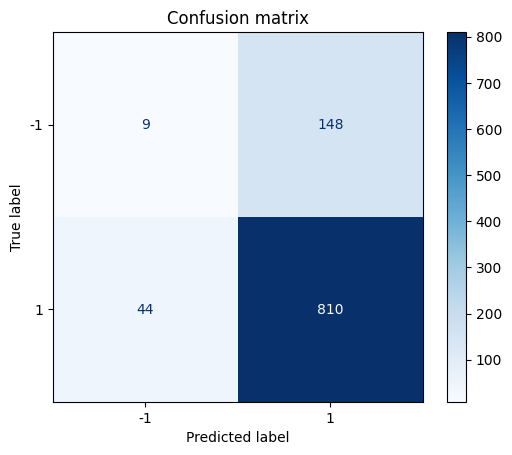

In [64]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
clf,
X_test,
y_test,
display_labels=model.classes_,
cmap=plt.cm.Blues
)
plt.title('Confusion matrix')
plt.show()

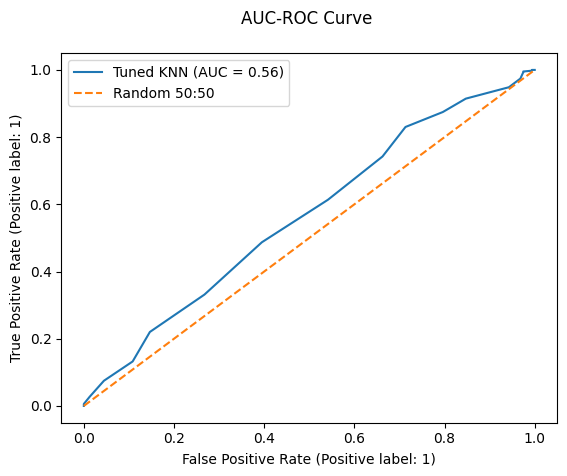

In [65]:
# Display ROCCurve
disp = RocCurveDisplay.from_estimator(
clf,
X_test,
y_test,
name='Tuned KNN')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

In [66]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.17      0.06      0.09       157
           1       0.85      0.95      0.89       854

    accuracy                           0.81      1011
   macro avg       0.51      0.50      0.49      1011
weighted avg       0.74      0.81      0.77      1011



# Trading Strategy

In [67]:
# Subsume into a new dataframe
df1 = df.copy() # df[-len(X_test)
df1['Signal'] = clf.predict(X) # clf.predict(X_test)

In [68]:
# Daily Returns - Benchmark return
df1['Returns'] = np.log(df1['Adj Close']).diff().fillna(0)

# Strategy Returns - KNN
df1['Strategy'] = df1['Returns'] * df1['Signal'].shift(1).fillna(0)

# Localize index for pyfolio
df1.index = df1.index.tz_convert('utc')

In [69]:
# Check the output
df1.tail(10)

,Open,High,Low,Close,Adj Close,Volume,Signal,Returns,Strategy
Date,,,,,,,,,
2020-01-17 05:00:00+00:00,331.700012,332.179993,330.850006,331.950012,312.970520,95846000,1,0.003108,0.003108
2020-01-21 05:00:00+00:00,330.899994,332.179993,330.820007,331.299988,312.357605,77742400,1,-0.001960,-0.001960
2020-01-22 05:00:00+00:00,332.239990,332.950012,331.170013,331.339996,312.395294,48914900,1,0.000121,0.000121
2020-01-23 05:00:00+00:00,330.630005,332.170013,329.410004,331.720001,312.753540,51963000,1,0.001146,0.001146
2020-01-24 05:00:00+00:00,332.440002,332.529999,327.359985,328.769989,309.972290,87578400,1,-0.008933,-0.008933
2020-01-27 05:00:00+00:00,323.029999,325.119995,322.660004,323.500000,305.003571,84062500,-1,-0.016159,-0.016159
2020-01-28 05:00:00+00:00,325.059998,327.850006,323.600006,326.890015,308.199768,63834000,-1,0.010425,-0.010425
2020-01-29 05:00:00+00:00,328.380005,328.630005,326.399994,326.619995,307.945221,53888900,1,-0.000826,0.000826
2020-01-30 05:00:00+00:00,324.359985,327.910004,323.540009,327.679993,308.944580,75491800,-1,0.003240,0.003240


## Return Analysis

In [70]:
import pyfolio as pf

In [71]:
# Create Tear sheet using pyfolio for outsample - for X_test
# pf.create_simple_tear_sheet(df1['Strategy'])

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,46.62,2007-10-09,2008-10-29,2011-01-14,854
1,32.44,2000-03-23,2001-09-19,2003-05-15,820
2,14.41,2011-02-18,2011-08-05,2011-08-29,136
3,13.64,2018-09-20,2018-12-24,2019-02-15,107
4,11.17,2000-01-10,2000-02-25,2000-03-23,54


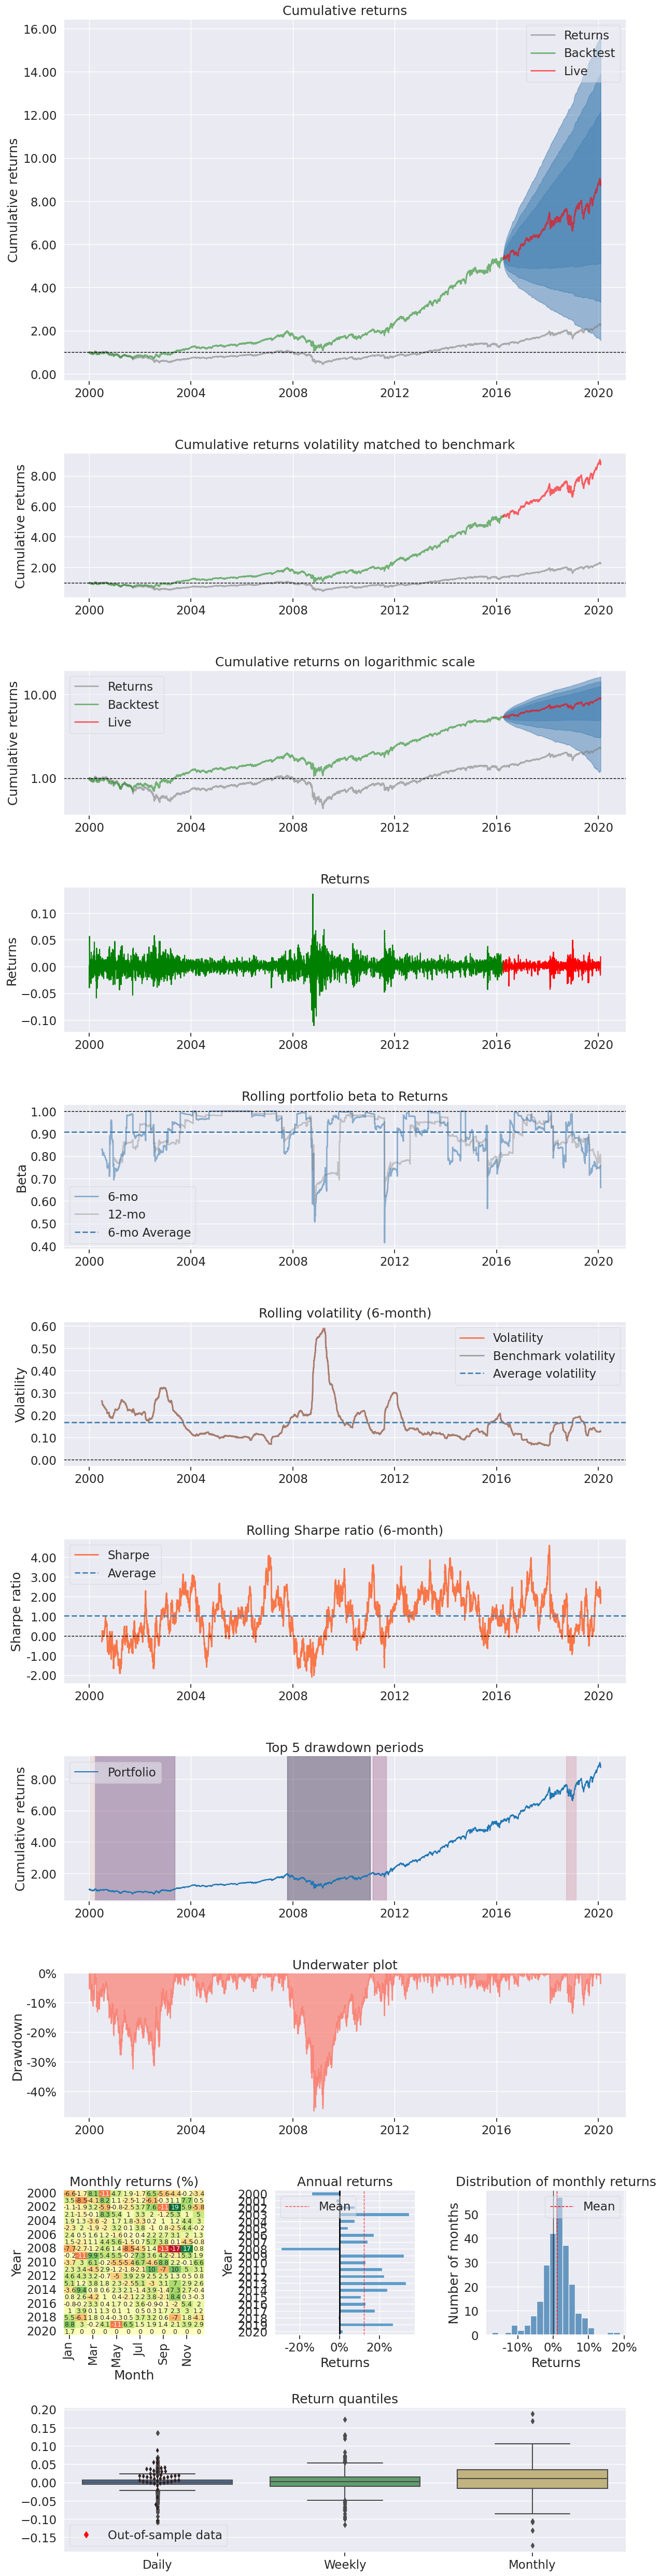

In [72]:
# Live start date 2016-04-07
pf.create_returns_tear_sheet(
    df1["Strategy"], live_start_date="2016-04-07", benchmark_rets=df1["Returns"]
)